In [21]:
%%html
<style>
table {float:left}
</style>

# Convolution NN for first break picking

* [Task description](#Task-description)
* [Datasets](#Datasets)
* [Model architecture](#Model-Architecture)
* [Training](#Training)
* [Inference](#Inference)
* [Model evaluation](#Model-evaluation)
* [Conclusion](#Conclusion)

## Task description

First-break picking is the task of determining, given a set of raw seismic traces, the onsets of the first signal arrivals as accurately as possible. The accurate determination of the first arrivals onset first-break times is needed for calculating the static corrections, a fundamental stage of seismic data processing.

## Datasets

We exploit raw traces from the Dataset 1 as training examples. We will test our model on the traces from seismofields, the model did not see during training.   
All datasets descriptions are avaliable here [here](https://github.com/analysiscenter/SeismicPro/blob/master/datasets/first_break_picking.ipynb).

| Filename | About this file | Size | N ffid | Length |
| :------ | ----: | ----: | ----: | ----: |
| Pal_Flatiron_1k.sgy | Raw field seismogram | 2.5 Gb | 1001 | 1.4 s |
| Pal_Flatiron_1k_picking.csv | First break time | 16 Mb | 1001 | - |

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')

from seismicpro.batchflow import Pipeline, Dataset, B, V
from seismicpro.batchflow.models.torch import UNet
from seismicpro.src import FieldIndex, TraceIndex

from picking import test_pipeline, PickingBatch, PickingMetrics, seismic_plot

Specify the paths to SEGY file, as well as labeled picking data.

In [2]:
path_raw = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k.sgy'
markup_path = '/notebooks/egor/FB/Pal/Pal_Flatiron_1k_picking.csv'
index = FieldIndex(name='raw', path=path_raw, markup_path=markup_path)

Load the first field 10407 from the dataset for vizualization.

In [3]:
batch = (Dataset(index, PickingBatch).next_batch(batch_size=1)
        .load(components='raw', fmt='segy')
        .load(components='markup', fmt='picks'))

Plot the whole seismogram and 10 first traces with labeled picking.

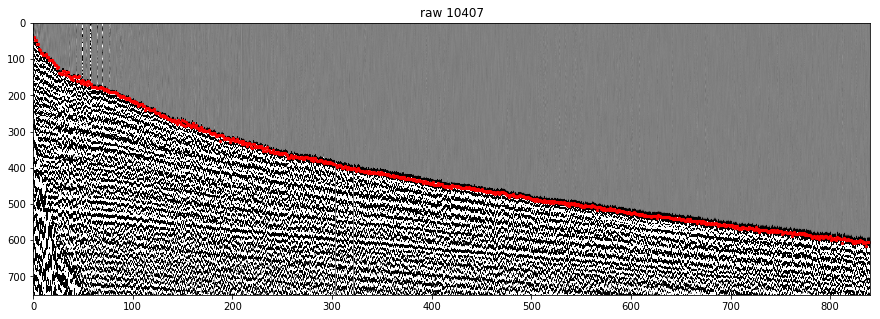

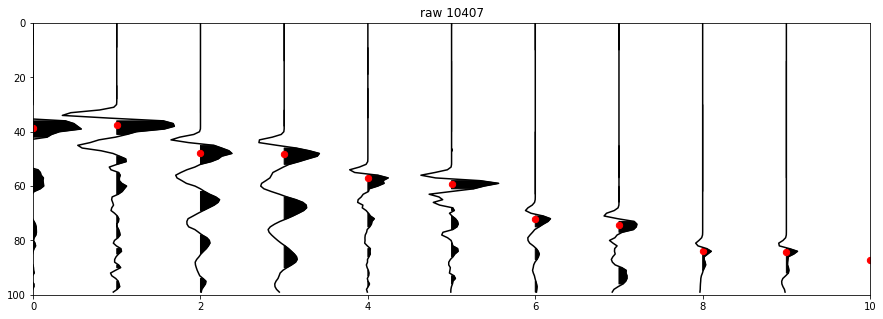

In [4]:
cv = 1000
(batch.seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                     figsize=(15,5), vmax=cv, vmin=-cv, s=5, c='r')
      .seismic_plot('raw', index.indices[0], src_picking='markup', cmap='gray',
                    figsize=(15,5), vmax=cv, vmin=-cv, s=40, c='r', wiggle=True, xlim=(0,10), ylim=(0,100), std=0.01))

Set train and test fields.   
We train the model on the three fields and validate on the fourth.

In [5]:
train_index = index.create_subset(index.indices[:3])
train_data = Dataset(TraceIndex((train_index)), PickingBatch)

In [6]:
test_index = index.create_subset(index.indices[4:5])
test_data = Dataset(TraceIndex((test_index)), PickingBatch)

## Model Architecture

We are using Unet type of model with 4 blocks

In [7]:
inputs_config = {
    'raw': {'shape': (1, 753)}, 
    'mask': {'shape': (1, 753),
              'classes': 2,
              'data_format': 'f',
              'name': 'targets'}
    }

In [8]:
%env CUDA_VISIBLE_DEVICES=4
config = {
    'inputs': inputs_config,
    'initial_block/inputs': 'raw',
    'optimizer': ('Adam', {'lr': 0.005}),
    'head/num_classes': 2, 
    'body/num_blocks': 4,
    'body/filters': [8, 16, 32, 64], 
    'body/encoder': dict(layout='cna cna', kernel_sizee=5),
    'body/decoder': dict(layout='cna cna', kernel_size=5),
    'device': 'cuda',
}

env: CUDA_VISIBLE_DEVICES=4


## Training

There are some load and data processing actions in the pipeline.

In [9]:
train_pipeline = (train_data.p
                      .init_model('dynamic', UNet, 'my_model', config=config)
                      .load(components='raw', fmt='segy')
                      .load(components='markup', fmt='picks')
                      .drop_zero_traces(num_zero=700, src='raw')
                      .normalize_traces(src='raw', dst='raw')
                      .mask_to_picking(src='markup', dst='mask')
                      .init_variable('loss', init_on_each_run=list)
                      .train_model('my_model', B('raw'), B('mask'), 
                                   fetches='loss', save_to=V('loss'), mode='a'))

In [ ]:
train_pipeline.run(batch_size=64, n_iters=10, shuffle=42, drop_last=True, bar=True, init_vars=False)

Loss function plot

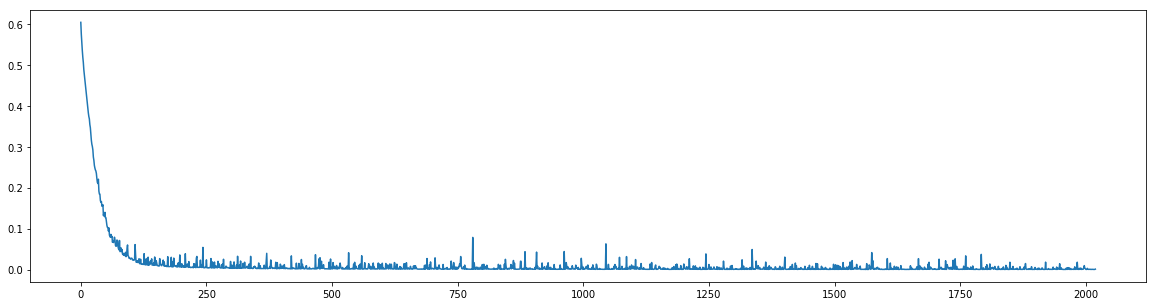

In [21]:
loss = train_pipeline.get_variable('loss')
plt.figure(figsize=(20, 5))
plt.plot(loss)

## Inference

Inference pipeline:

In [13]:
test_pipe = test_pipeline(train_pipeline)
test  = (test_pipe << test_data).run(1000, n_epochs=1, drop_last=False, shuffle=False, bar=True)


  0%|          | 0/1 [00:00<?, ?it/s]


## Model evaluation

In [14]:
pred = np.vstack(test.get_variable('predictions')).flatten()
true = np.argmax(np.vstack(test.get_variable('picking')), axis=1)
raw = np.vstack(np.concatenate(test.get_variable('traces')))

Take a look at some metrics.   

In [15]:
metrics = PickingMetrics(true, pred, diff=3)

MAE stands for Mean Absolute Error - how much model picking deviates from ground trurh on the avarage in absolute terms

In [16]:
print('MAE on the test: {0:.3f}'.format(metrics.evaluate('MAE')))

MAE on the test: 0.089


Even though picking is a regression task, we can consider its classification interpretation.   
If ground truth and model picking differs on 3 or more in absolute terms - we consider such trace as not properly classified.

In [17]:
print('Accuracy on the test: {0:.2f}%'.format(metrics.evaluate('accuracy')))

Accuracy on the test: 98.80%


Take a look at the predictions and labels on the whole seismograms.

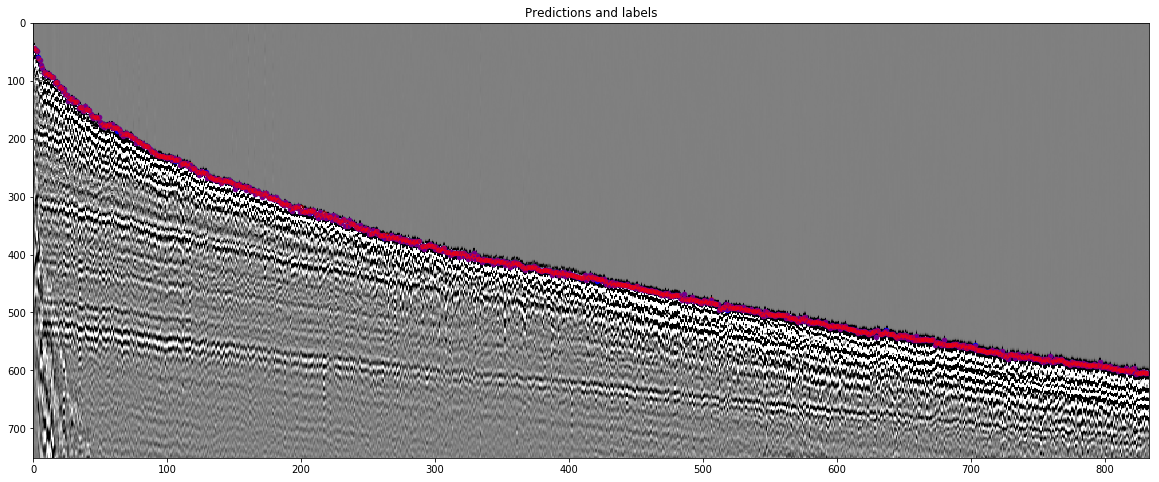

In [18]:
cv = 1
s = 20
pts_pred = (range(len(pred)), pred)
pts_real = (range(len(true)), true)
pts = [pts_pred, pts_real]
seismic_plot(raw, cmap='gray',vmax=cv, vmin=-cv, pts=pts, s=s, c = ['b', 'r'], figsize=(20, 8), names=['Predictions and labels'])

Take a closer look at the  10 traces from  the seismogram.

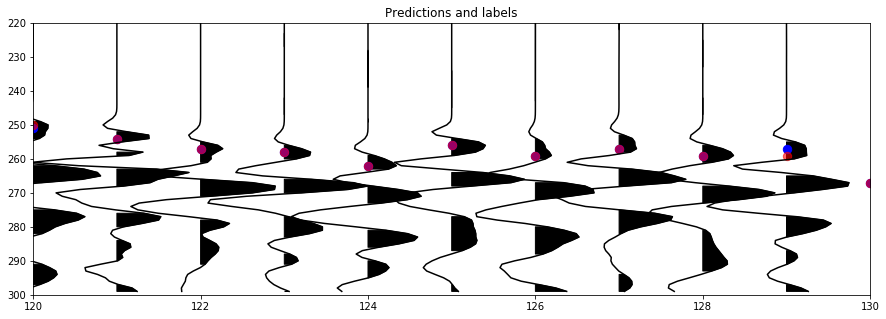

In [20]:
s = 70
std = 0.1
xlim = (120, 130)
ylim = (220, 300)
seismic_plot(raw, cmap='gray', wiggle=True, pts=pts, vmax=cv, cmin=-cv,
             figsize=(15, 5), s = s, c=['b', 'r'], std = std, ylim=ylim, xlim=xlim, names=['Predictions and labels'])

## Conclusion

The model generalises the pattern of first break picking and shows fair results on the validation on the traces from different fields rather than training ones.   
However, there are some open challenges like the presense of significant noise in the traces which forces the model to make uncorrect predictions.